In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, sys
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.stats.api as sms

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [7]:
module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')

In [4]:
from DL_utils import parallel_coordinates

In [4]:
from ccs_tools import core_dtypes_pd
from utils import preprocess

Using TensorFlow backend.


In [8]:
folder = 'multi_space_glove/'
DX1_freq = pd.read_csv(path+folder+'DX1_freq.csv', dtype={'DX1':str, 'frequency':int})
DX_freq = pd.read_csv(path+folder+'DX_freq.csv', dtype={'DX':str, 'frequency':int})
PR_freq = pd.read_csv(path+folder+'PR_freq.csv', dtype={'PR':str, 'frequency':int})

In [14]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [16]:
DX1_rarecutpoint = 10
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [17]:
DX1_freq = DX1_freq.loc[DX1_freq.frequency>0]
DX_freq = DX_freq.loc[DX_freq.frequency>0]
PR_freq = PR_freq.loc[PR_freq.frequency>0]
DX1_cat = sorted(DX1_freq.loc[(DX1_freq.frequency>DX1_rarecutpoint) & (~DX1_freq.DX1.isin(unclassified))].DX1)
DX_cat = sorted(DX_freq.loc[(DX_freq.frequency>DX_rarecutpoint) & (~DX_freq.DX.isin(unclassified))].DX)
PR_cat = sorted(PR_freq.loc[(PR_freq.frequency>PR_rarecutpoint)].PR)
n_DX1_cat = len(DX1_cat)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

In [18]:
len(set(DX1_cat).union(set(DX_cat)))

9778

In [19]:
len(PR_cat)

3183

## Editing pbs Files

In [2]:
!rm batch_gpu*.pbs

In [3]:
for job_index in range(12):
    with open('batch_gpu{}.pbs'.format(job_index), 'w') as f:
        f.write("""#!/bin/sh

#### PBS preamble

#PBS -N NRD_hypertune{}

#PBS -M wsliu@umich.edu
#PBS -m abe

#PBS -A awaljee_fluxg

#PBS -q fluxg

#PBS -V
#PBS -l nodes=1:gpus={},mem={}gb,walltime={}:00:00
#PBS -j oe

#### End PBS preamble

#  Show list of CPUs you ran on, if you're running under PBS
if [ -n "$PBS_NODEFILE" ]; then cat $PBS_NODEFILE; fi

#  Change to the directory you submitted from
if [ -n "$PBS_O_WORKDIR" ]; then cd $PBS_O_WORKDIR; fi

#  Put your job commands here:
sh hypertune{}.sh""".format(job_index, '1', 7, 72, job_index))

## Prepare hyper-parameters and generate the .sh files

For embedding+NN with a subset of codes:

In [3]:
!rm hypertune*.sh

In [36]:
model_names = ['setsum_nn', 'setsum_deep2']
DX1_dims = [30]
DX_dims = [200]
PR_dims = [100]
fc_widths = [256, 512, 1024]
#md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0.3]
batchsizes = [256, 512, 1024]
embed_files = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [20, 100, 200]
tst_seeds = [0]
cohorts = ['ami']
DX_rarecutpoints = [10, 90, 180, 270]
PR_rarecutpoints = [10, 90, 180, 270]
val_folds = [7]
other_preds = [0, 1]
ndxprs = [0]
result_files = ['output/ht_result1224_{}.csv']

For embedding+NN with all codes:

In [3]:
model_names = ['setsum_nn']
DX1_dims = [200]
DX_dims = [200]
PR_dims = [50]
fc_widths = [512]
#md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0.3]
batchsizes = [512]
embed_files = ['pretrain']
penalties = [0.]
penalty_metrics = ['cosine']
count_caps = [20]
tst_seeds = range(10)
cohorts = ['ami', 'chf', 'pna']
DX1_rarecutpoints = [10]
DX_rarecutpoints = [10]
PR_rarecutpoints = DX_rarecutpoints
val_folds = [9]
other_preds = [0]
ndxprs = [0]
result_files = ['output/ht_result0224_{}.csv']

In [37]:
para_itr = itertools.product(model_names, DX1_dims, DX_dims, PR_dims, fc_widths, lr1s, lr2s, dropouts, batchsizes, embed_files, 
                             count_caps, tst_seeds, cohorts, DX_rarecutpoints, other_preds, ndxprs, val_folds, 
                             result_files)
para_lst = [(mn, dx1d, dxd, prd, fc, l1, l2, do, bs, em, cc, ts, ch, dxr, dxr, op, ndp, vf, rf) 
            for mn, dx1d, dxd, prd, fc, l1, l2, do, bs, em, cc, ts, ch, dxr, op, ndp, vf, rf in para_itr]

In [16]:
para_itr = itertools.product(model_names, DX1_dims, DX_dims, PR_dims, fc_widths, lr1s, lr2s, dropouts, batchsizes, embed_files, 
                             count_caps, tst_seeds, cohorts, DX_rarecutpoints, PR_rarecutpoints, other_preds, ndxprs, val_folds, 
                             result_files)
para_lst = list(para_itr)

In [4]:
para_itr = itertools.product(model_names, DX1_dims, DX_dims, PR_dims, fc_widths, lr1s, lr2s, dropouts, batchsizes, embed_files, 
                             penalties, penalty_metrics, count_caps, tst_seeds, cohorts, DX1_rarecutpoints, DX_rarecutpoints, 
                             PR_rarecutpoints, other_preds, ndxprs, val_folds, result_files)
para_lst = list(para_itr)

In [5]:
len(para_lst)

30

In [6]:
job_lst = range(1, 7)
for para, job_ind in zip(para_lst, itertools.cycle(job_lst)):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python template_all_multispace0102.py --model_name {} --DX1_dim {} --DX_dim {} --PR_dim {} --fc_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --penalty {} --penalty_metric {} --count_cap {} --tst_seed {} --cohort {} --dx1_rarecutpoint {} --dx_rarecutpoint {} --pr_rarecutpoint {} --other_pred {} --ndxpr {} --val_fold {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [6]:
n_jobs = 10
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python template_all_multispace_notest.py --model_name {} --DX1_dim {} --DX_dim {} --PR_dim {} --fc_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --penalty {} --penalty_metric {} --count_cap {} --tst_seed {} --cohort {} --dx1_rarecutpoint {} --dx_rarecutpoint {} --pr_rarecutpoint {} --other_pred {} --ndxpr {} --val_fold {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [12]:
job_ind = 2
for para in para_lst:
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python template_all_multispace0102.py --model_name {} --DX1_dim {} --DX_dim {} --PR_dim {} --fc_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --penalty {} --penalty_metric {} --count_cap {} --tst_seed {} --cohort {} --dx1_rarecutpoint {} --dx_rarecutpoint {} --pr_rarecutpoint {} --other_pred {} --ndxpr {} --val_fold {} --result_file {} --job_index {}\n'.format(*para, job_ind))

Random search:

In [36]:
n_sample = 40

In [37]:
model_names = np.random.choice(['setsum_nn'], n_sample)
DX1_dims = np.random.choice([35], n_sample)
DX_dims = np.random.choice([200], n_sample)
PR_dims = np.random.choice([80], n_sample)
fc_widths = np.random.choice([450], n_sample)
#md_widths = np.random.choice([128, 256], n_sample)
lr1s = np.random.choice([2e-4], n_sample)
lr2s = np.random.choice([2e-5], n_sample)
dropouts = np.random.choice([0.3], n_sample)
batchsizes = np.random.choice([512], n_sample)
embed_files = np.random.choice(['pretrain'], n_sample)
#penalties = np.random.choice([0, 0.5, 1.], n_sample)
#penalty_metrics = np.random.choice(['cosine'], n_sample)
count_caps = np.random.choice([120], n_sample)
tst_seeds = np.random.choice([0], n_sample)
cohorts = np.random.choice(['ami'], n_sample)
DX_rarecutpoints = np.random.choice([10], n_sample)
PR_rarecutpoints = DX_rarecutpoints
val_folds = np.random.choice([5], n_sample)
other_preds = np.random.choice([0], n_sample)
ndxprs = np.random.choice([0], n_sample)
result_files = ['output/ht_result0101_{}.csv']*n_sample

In [38]:
zips = zip(model_names, DX1_dims, DX_dims, PR_dims, fc_widths, lr1s, lr2s, dropouts, batchsizes, embed_files, 
            count_caps, tst_seeds, cohorts, DX_rarecutpoints, PR_rarecutpoints, other_preds, ndxprs, val_folds, result_files)

In [39]:
para_lst = list(zips)

In [40]:
len(para_lst)

40

In [41]:
n_jobs = 8
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python template_sub_multispace1218.py --model_name {} --DX1_dim {} --DX_dim {} --PR_dim {} --fc_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --count_cap {} --tst_seed {} --cohort {} --dx_rarecutpoint {} --pr_rarecutpoint {} --other_pred {} --ndxpr {} --val_fold {} --result_file {} --job_index {}\n'.format(*para, job_ind))

## Result Analysis

### Embedding + NN  with subset of codes

In [2]:
res = pd.DataFrame()

In [43]:
for job_ind in range(12):
    df = pd.read_csv('output/ht_result1231_'+str(job_ind)+'.csv', 
                     names=['model_name', 'DX1_dim', 'DX_dim', 'PR_dim', 'hosp_embed_dim', 'fc_width', 'lr1', 'lr2', 'dropout',
                            'batchsize', 'embed_file', 'cohort', 'tst_seed', 'n_fold', 'count_cap', 
                            'DX_rarecutpoint', 'PR_rarecutpoint', 'other_pred', 'ndxpr', 'auc_mean', 'auc_avg', 'auc_freeze', 'y_pred_file'], index_col=None)
    res = pd.concat([res, df])

In [4]:
res.head()

,model_name,DX1_dim,DX_dim,PR_dim,hosp_embed_dim,fc_width,lr1,lr2,dropout,batchsize,...,n_fold,count_cap,DX_rarecutpoint,PR_rarecutpoint,other_pred,ndxpr,auc_mean,auc_avg,auc_freeze,y_pred_file
0,setsum_nn,30,200,80,1,256,0.0002,0.00002,0.3,512,...,5,200,10,10,0,0,0.71322,0.71661,0.71294,output/y_pred_mat19_01_01_12_09_09.npy
1,setsum_nn,35,200,80,1,512,0.0002,0.00002,0.3,400,...,5,200,180,180,0,0,0.71357,0.71611,0.71263,output/y_pred_mat19_01_01_12_37_00.npy
2,setsum_nn,35,200,80,1,256,0.0002,0.00002,0.3,400,...,5,200,10,10,0,0,0.71341,0.71604,0.71260,output/y_pred_mat19_01_01_01_15_47.npy
3,setsum_nn,30,200,80,1,512,0.0002,0.00002,0.3,512,...,5,120,10,10,0,0,0.71352,0.71651,0.71263,output/y_pred_mat19_01_01_01_51_13.npy
4,setsum_nn,35,200,80,1,256,0.0002,0.00002,0.3,400,...,5,120,10,10,0,0,0.71340,0.71643,0.71255,output/y_pred_mat19_01_01_02_29_38.npy


In [27]:
res.shape

(600, 23)

In [44]:
res_grouped = res.loc[res.auc_freeze>0.7135].groupby(['model_name', 'DX1_dim', 'DX_dim', 'PR_dim', 'fc_width', 'count_cap', 
                                                     'batchsize', 'DX_rarecutpoint'])

In [30]:
res_grouped = res.groupby(['model_name', 'DX1_dim', 'DX_dim', 'PR_dim', 'fc_width', 'count_cap', 'batchsize', 'DX_rarecutpoint'])

In [45]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze  \
                                                                                    mean   
model_name DX1_dim DX_dim PR_dim fc_width count_cap batchsize DX_rarecutpoint              
setsum_nn  30      200    80     256      120       400       30                0.713550   
                                          200       512       30                0.714043   
                                 512      120       512       180               0.713530   
                                          200       512       30                0.713580   
                                                              180               0.713640   
           35      200    80     256      120       400       180               0.713940   
                                                    512       30                0.713785   
                                          200       400       180               0.713660   
                                 512      120       400       30                0.713660   
                                          200       400       30                0.714150   
                                                    512       10                0.713540   
                                                              180               0.713970   

                                                                                     \
                                                                              count   
model_name DX1_dim DX_dim PR_dim fc_width count_cap batchsize DX_rarecutpoint         
setsum_nn  30      200    80     256      120       400       30                  1   
                                          200       512       30                  3   
                                 512      120       512       180                 1   
                                          200       512       30                  2   
                                                              180                 1   
           35      200    80     256      120       400       180                 1   
                                                    512       30                  2   
                                          200       400       180                 1   
                                 512      120       400       30                  2   
                                          200       400       30                  1   
                                                    512       10                  1   
                                                              180                 1   

                                                                               auc_mean  \
                                                                                   mean   
model_name DX1_dim DX_dim PR_dim fc_width count_cap batchsize DX_rarecutpoint             
setsum_nn  30      200    80     256      120       400       30               0.714240   
                                          200       512       30               0.714643   
                                 512      120       512       180              0.713990   
                                          200       512       30               0.714210   
                                                              180              0.714190   
           35      200    80     256      120       400       180              0.714160   
                                                    512       30               0.714535   
                                          200       400       180              0.714350   
                                 512      120       400       30               0.714130   
                                          200       400       30               0.714600   
                                                    512       10               0.714160   
                                                              180              0.714100   

                         

In [31]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count']).shape

(600, 6)

In [46]:
res.to_csv('output/ht_result1231.csv', index=False)

In [34]:
res.loc[(res.DX1_dim==35)&(res.DX_dim==200)&(res.PR_dim==80)&(res.count_cap==120)&(res.DX_rarecutpoint==10)&(res.batchsize==512)
       &(res.fc_width==450)]

,model_name,DX1_dim,DX_dim,PR_dim,hosp_embed_dim,fc_width,lr1,lr2,dropout,batchsize,...,n_fold,count_cap,DX_rarecutpoint,PR_rarecutpoint,other_pred,ndxpr,auc_mean,auc_avg,auc_freeze,y_pred_file


In [20]:
res = pd.read_csv('output/ht_result1227.csv')

In [19]:
res2 = pd.read_csv('output/ht_result1219.csv')

In [22]:
res2.loc[res2.auc_freeze>0.7135]

,model_name,DX1_dim,DX_dim,PR_dim,hosp_embed_dim,fc_width,lr1,lr2,dropout,batchsize,...,tst_seed,n_fold,count_cap,DX_rarecutpoint,PR_rarecutpoint,other_pred,auc_mean,auc_avg,auc_freeze,y_pred_file
106,setsum_nn,20,200,100,1,256,0.0002,0.00002,0.3,512,...,0,7,1,10,5,0,0.71390,0.71700,0.71365,output/y_pred_mat18_12_20_11_23_06.npy
165,setsum_nn,20,200,100,1,512,0.0002,0.00002,0.3,512,...,0,7,100,10,5,0,0.71388,0.71674,0.71368,output/y_pred_mat18_12_19_11_12_36.npy
167,setsum_nn,40,200,100,1,256,0.0002,0.00002,0.3,512,...,0,7,5,10,5,0,0.71465,0.71788,0.71376,output/y_pred_mat18_12_20_12_58_32.npy
170,setsum_nn,20,200,100,1,512,0.0002,0.00002,0.3,512,...,0,7,100,10,5,0,0.71478,0.71784,0.71381,output/y_pred_mat18_12_20_10_29_21.npy
209,setsum_nn,20,200,200,1,256,0.0002,0.00002,0.3,512,...,0,7,100,10,5,0,0.71434,0.71707,0.71374,output/y_pred_mat18_12_20_11_37_02.npy
217,setsum_nn,40,200,100,1,512,0.0002,0.00002,0.3,512,...,0,7,100,10,5,0,0.71418,0.71714,0.71358,output/y_pred_mat18_12_20_01_09_19.npy


### Embedding + NN  with all codes

In [2]:
res = pd.DataFrame()

In [4]:
for job_ind in range(1, 7):
    df = pd.read_csv('output/ht_result0224_'+str(job_ind)+'.csv', 
                     names=['model_name', 'DX1_dim', 'DX_dim', 'PR_dim', 'hosp_embed_dim', 'fc_width', 'lr1', 'lr2', 'dropout',
                            'batchsize', 'embed_file', 'cohort', 'tst_seed', 'n_fold', 'penalty', 'penalty_metric', 'count_cap', 
                            'DX1_rarecutpoint', 'DX_rarecutpoint', 'PR_rarecutpoint', 'other_pred', 'ndxpr', 'auc_mean', 'auc_avg', 
                            'auc_freeze', 'y_pred_file'], index_col=None)
    res = pd.concat([res, df])

In [5]:
res.head()

,model_name,DX1_dim,DX_dim,PR_dim,hosp_embed_dim,fc_width,lr1,lr2,dropout,batchsize,...,count_cap,DX1_rarecutpoint,DX_rarecutpoint,PR_rarecutpoint,other_pred,ndxpr,auc_mean,auc_avg,auc_freeze,y_pred_file
0,setsum_nn,200,200,50,1,512,0.0002,0.00002,0.3,512,...,20,10,10,10,0,0,0.71379,0.71656,0.71346,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...
1,setsum_nn,200,200,50,1,512,0.0002,0.00002,0.3,512,...,20,10,10,10,0,0,0.71874,0.72109,0.71821,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...
2,setsum_nn,200,200,50,1,512,0.0002,0.00002,0.3,512,...,20,10,10,10,0,0,0.71961,0.72252,0.71862,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...
3,setsum_nn,200,200,50,1,512,0.0002,0.00002,0.3,512,...,20,10,10,10,0,0,0.71056,0.71328,0.70962,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...
4,setsum_nn,200,200,50,1,512,0.0002,0.00002,0.3,512,...,20,10,10,10,0,0,0.71667,0.71937,0.71651,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...


In [5]:
res.shape

(120, 26)

In [10]:
res = pd.read_csv('output/ht_result0215.csv')

In [7]:
res_grouped = res.loc[res.auc_avg>0.6822].groupby(['DX1_dim', 'DX_dim', 'PR_dim', 'count_cap', 'fc_width', 'lr2',
                          'penalty_metric','penalty'])

In [8]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze  \
                                                                              mean   
DX1_dim DX_dim PR_dim count_cap fc_width lr2     penalty_metric penalty              
100     100    50     20        256      0.00002 l2             0.0        0.67742   
200     100    50     5         256      0.00001 l2             0.0        0.67772   
               100    5         256      0.00002 l2             0.0        0.67789   
                                                                0.5        0.67891   
        200    50     20        256      0.00001 cosine         0.0        0.67858   
                      100       256      0.00002 l2             0.0        0.67762   
                                512      0.00001 l2             0.0        0.67880   

                                                                               \
                                                                        count   
DX1_dim DX_dim PR_dim count_cap fc_width lr2     penalty_metric penalty         
100     100    50     20        256      0.00002 l2             0.0         1   
200     100    50     5         256      0.00001 l2             0.0         1   
               100    5         256      0.00002 l2             0.0         1   
                                                                0.5         1   
        200    50     20        256      0.00001 cosine         0.0         1   
                      100       256      0.00002 l2             0.0         1   
                                512      0.00001 l2             0.0         1   

                                                                        auc_mean  \
                                                                            mean   
DX1_dim DX_dim PR_dim count_cap fc_width lr2     penalty_metric penalty            
100     100    50     20        256      0.00002 l2             0.0      0.67786   
200     100    50     5         256      0.00001 l2             0.0      0.67825   
               100    5         256      0.00002 l2             0.0      0.67790   
                                                                0.5      0.67836   
        200    50     20        256      0.00001 cosine         0.0      0.67886   
                      100       256      0.00002 l2             0.0      0.67887   
                                512      0.00001 l2             0.0      0.67836   

                                                                               \
                                                                        count   
DX1_dim DX_dim PR_dim count_cap fc_width lr2     penalty_metric penalty         
100     100    50     20        256      0.00002 l2             0.0         1   
200     100    50     5         256      0.00001 l2             0.0         1   
               100    5         256      0.00002 l2             0.0         1   
                                                                0.5         1   
        200    50     20        256      0.00001 cosine         0.0         1   
                      100       256      0.00002 l2             0.0         1   
                                512      0.00001 l2             0.0         1   

                                                                         auc_avg  \
                                                                            mean   
DX1_dim DX_dim PR_dim count_cap fc_width lr2     penalty_metric penalty            
100     100    50     20        256      0.00002 l2             0.0      0.68223   
200     100    50     5         256      0.00001 l2             0.0      0.68258   
               100    5         256      0.00002 l2             0.0      0.68248   
                                                                0.5      0.68279   
        200    50     20        256      0.00001 cosine         0.0      0.68251   
                      100       256      0.00002 l2             0.0      0.6

In [25]:
parallel_coord_df = res[['DX1_dim', 'DX_dim', 'PR_dim', 'count_cap', 'fc_width', 'lr2',
                          'penalty_metric','penalty', 'auc_avg']]

In [26]:
parallel_coord_df.columns = ['DX1_dim', 'DX_dim', 'PR_dim', 'count_cap', 'fc_width', 'lr2',
                          'penalty_metric','penalty', 'score']

In [27]:
dict_lst = []
for _, r in parallel_coord_df.iterrows():
    dict_lst.append(r.to_dict())

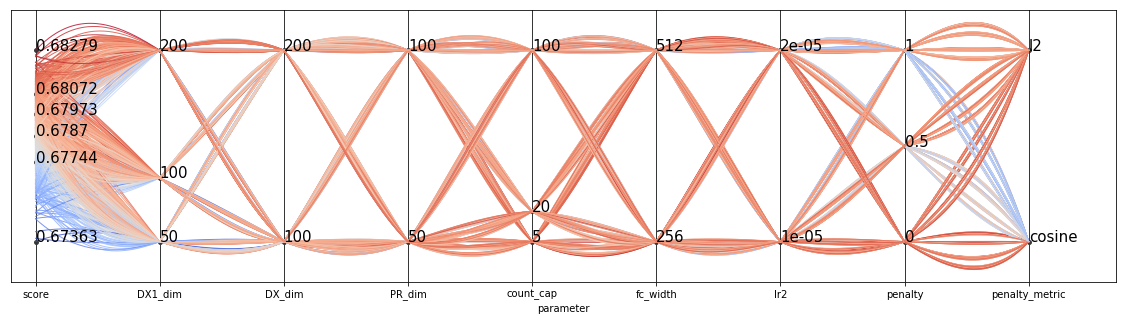

In [28]:
parallel_coordinates(dict_lst)

In [7]:
res = res.loc[(res.count_cap==5)&(res.penalty==0)]

In [5]:
res_grouped = res.groupby(['cohort', 'count_cap', 'penalty'])

In [5]:
res_grouped = res.groupby(['cohort'])

In [6]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze        auc_mean         auc_avg      
             mean count      mean count      mean count
cohort                                                 
ami      0.678916    10  0.679674    10  0.683057    10
chf      0.612788    10  0.614202    10  0.618309    10
pna      0.650691    10  0.651955    10  0.655777    10

In [13]:
res.loc[(res.cohort=='ami') & (res.tst_seed==0)]

,model_name,DX1_dim,DX_dim,PR_dim,hosp_embed_dim,fc_width,lr1,lr2,dropout,batchsize,...,count_cap,DX1_rarecutpoint,DX_rarecutpoint,PR_rarecutpoint,other_pred,ndxpr,auc_mean,auc_avg,auc_freeze,y_pred_file
0,setsum_nn,200,200,100,1,512,0.0002,0.00002,0.3,512,...,5,10,10,10,0,0,0.6779,0.68192,0.67849,/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_...


In [10]:
for n, g in res_grouped:
    print(n, 'freeze: {0:.3f} ({1:.3f})'.format(g.auc_freeze.mean(), g.auc_freeze.std()/np.sqrt(len(g))), 
         'mean: {0:.3f} ({1:.3f})'.format(g.auc_mean.mean(), g.auc_mean.std()/np.sqrt(len(g))), 
         'avg: {0:.3f} ({1:.3f})'.format(g.auc_avg.mean(), g.auc_avg.std()/np.sqrt(len(g))))

ami freeze: 0.715 (0.002) mean: 0.716 (0.002) avg: 0.718 (0.002)
chf freeze: 0.625 (0.002) mean: 0.627 (0.002) avg: 0.630 (0.002)
pna freeze: 0.671 (0.001) mean: 0.672 (0.001) avg: 0.675 (0.001)


In [7]:
for n, g in res_grouped:
    print(n, 'freeze: {0:.3f} ({1:.3f}, {2:.3f})'.format(g.auc_freeze.mean(), *sms.DescrStatsW(g.auc_freeze).zconfint_mean()), 
         'mean: {0:.3f} ({1:.3f}, {2:.3f})'.format(g.auc_mean.mean(), *sms.DescrStatsW(g.auc_mean).zconfint_mean()), 
         'avg: {0:.3f} ({1:.3f}, {2:.3f})'.format(g.auc_avg.mean(), *sms.DescrStatsW(g.auc_avg).zconfint_mean()))

ami freeze: 0.679 (0.676, 0.682) mean: 0.680 (0.677, 0.683) avg: 0.683 (0.680, 0.686)
chf freeze: 0.613 (0.610, 0.615) mean: 0.614 (0.612, 0.616) avg: 0.618 (0.616, 0.621)
pna freeze: 0.651 (0.648, 0.653) mean: 0.652 (0.649, 0.655) avg: 0.656 (0.653, 0.658)


In [8]:
res.to_csv('output/ht_result0224.csv', index=False)